In [1]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.helper import npa_to_seq
import timeit


from getdist.mcsamples import  MCSamples
from getdist import plots

import getdist
sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
from GCR import GCRQuery
table_redmapper_halos = fits.open("catalogs/redmapper_halos.fits")[1].data
Ncm.cfg_init()
%matplotlib inline

In [2]:
pz_min = 0.1
pz_max = 1.1
logRmin = 0
logRmax = 3 

# We are loading the cosmoDC2_redmapper catalalog with richness
redmapper_cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_redmapper_v0.8.1")

# Taking some important information about the fiducial cosmological model and survey region
redmapper_cosmology = redmapper_cat.cosmology
sky_area = redmapper_cat.sky_area
# Listing all quantities in the choosen catalog
#np.sort(redmapper_cat.list_all_quantities())
#print(np.sort(redmapper_cat.list_all_quantities()))



#image_cat['halo_mass'].size()

data_redmapper = redmapper_cat.get_quantities(
    ["cluster_id", "redshift", "redshift_err", "richness", "richness_err", "ra", "dec"],
    filters=[
        f"redshift > {pz_min}",
        f"redshift < {pz_max}",
        f"richness > {10**logRmin}",
        f"richness < {10**logRmax}",
    ],
)
'''
table_redmapper_halos = fits.open("catalogs/redmapper_matched.fits")[1].data
data_redmapper = table_redmapper_halos
data_redmapper = Table(data_redmapper)
data_redmapper.rename_column('R', 'richness')
data_redmapper.rename_column('z', 'redshift')
data_redmapper.rename_column('z_err', 'redshift_err')
data_redmapper.rename_column('RA', 'ra')
data_redmapper.rename_column('DEC', 'dec')
'''

print("ra interval")
print(data_redmapper['ra'].min())
print(data_redmapper['ra'].max())
print('\n')

print("dec interval")
print(data_redmapper['dec'].min())
print(data_redmapper['dec'].max())
print('\n')

print("z interval")
print(data_redmapper['redshift'].min())
print(data_redmapper['redshift'].max())
print('\n')

print("richness interval")
print(data_redmapper['richness'].min())
print(data_redmapper['richness'].max())
print('\n')

print("sky_area = %.3f sqd" % (sky_area))
print(sky_area * (np.pi / 180) ** 2)
data_redmapper = Table(data_redmapper)
data_redmapper['richness'] = np.log(data_redmapper['richness'])


cut = data_redmapper['richness'].min()
lnR_max = np.log(200)

ra interval
47.83447574575201
75.9017151136021


dec interval
-46.51396804274271
-24.68019523136432


z interval
0.100568734
1.0998727


richness interval
5.007845
266.29504


sky_area = 439.790 sqd
0.13396765544773198


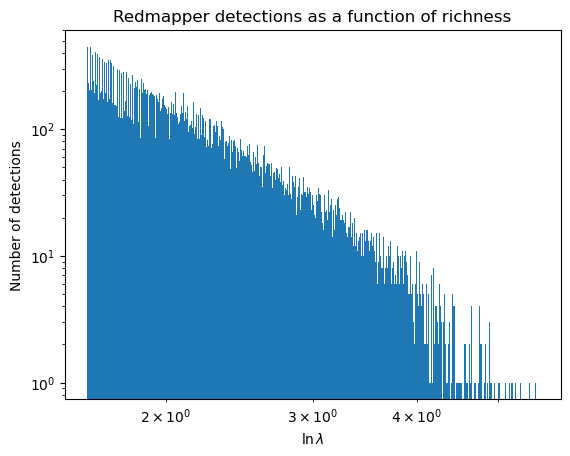

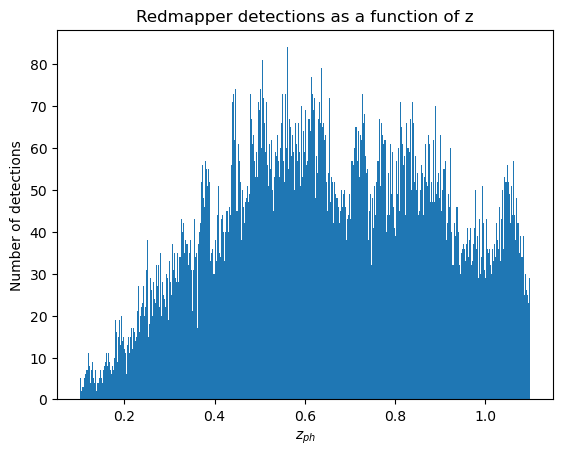

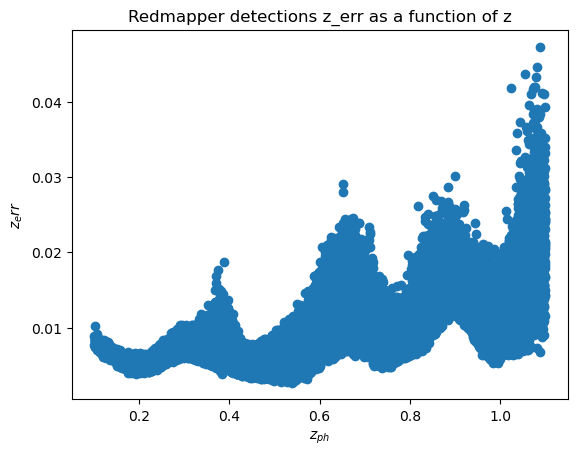

In [3]:
plt.hist(data_redmapper['richness'],bins=1000)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper detections as a function of richness")
plt.show()

plt.hist(data_redmapper['redshift'],bins=1000)
plt.title("Redmapper detections as a function of z")
plt.ylabel("Number of detections")
plt.xlabel(r"$z_{ph}$")
plt.show()


plt.scatter(data_redmapper['redshift'], data_redmapper['redshift_err'])
plt.title("Redmapper detections z_err as a function of z")
plt.ylabel(r"$z_e{rr}$")
plt.xlabel(r"$z_{ph}$")
plt.show()

# Completeness Model

In [4]:
lnM_bins_knots = np.linspace(13.0 * np.log(10), 16 * np.log(10) ,10)
z_bins_knots = np.array([0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnM_centers = 0.5 * (lnM_bins_knots[:-1] + lnM_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])

completeness_knots = Ncm.Matrix.new(len(z_centers),len(lnM_centers))

completeness_smooth_clipped = np.array([[0.03883302, 0.0556372,  0.06203133, 0.06041939, 0.05320534, 0.04279318,
  0.03158687, 0.0185471,  0.01724289],
 [0.23745306, 0.26637725, 0.27993941, 0.28153087, 0.27454294, 0.26236697,
  0.24839427, 0.23148489, 0.2296091 ],
 [0.40082567, 0.43698053, 0.45589722, 0.4615487,  0.45790797, 0.44894802,
  0.43864183, 0.42934926, 0.43937571],
 [0.54218907, 0.58072969, 0.60228042, 0.61110568, 0.61146987, 0.60763743,
  0.60387276, 0.60768125, 0.63562958],
 [0.6747815,  0.71090737, 0.7314647,  0.74083457, 0.74339807, 0.74353626,
  0.74563023, 0.76202187, 0.8074576 ],
 [0.81184117, 0.84079621, 0.85582574, 0.86136818, 0.86186199, 0.86174559,
  0.86545742, 0.88791217, 0.94394664],
 [0.96660632, 0.98367886, 0.9877392,  0.98333928, 0.97503107, 0.96736649,
  0.96489751, 0.98089315, 1.0        ],
 [0.96660632, 0.98367886, 0.9877392,  0.98333928, 0.97503107, 0.96736649,
  0.96489751, 0.98089315, 1.0        ],
 [0.96660632, 0.98367886, 0.9877392,  0.98333928, 0.97503107, 0.96736649,
  0.96489751,  0.98089315, 1.0        ]])
'''
completeness_smooth_clipped = np.array([[1, 1, 1, 1, 1, 1,
 1 , 1 , 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1]])
'''
for i in range(len(z_centers)):
    for j in range(len(lnM_centers)):
        completeness_knots.set(i,j, completeness_smooth_clipped.T[i][j])

completeness = Ncm.Spline2dBicubic(
spline=Ncm.SplineCubicNotaknot.new(),
x_vector=Ncm.Vector.new_array(npa_to_seq(lnM_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=completeness_knots
)
completeness.prepare()
completeness.integ_dxdy(np.log(1e13), np.log(1e16), 0.1, 1.1)

4.512495514425456

# Purity Model

In [5]:
lnR_bins_knots = np.log(np.array([5, 10, 15, 20, 35, 70, 100, 200]))
z_bins_knots = np.array([0.1, 0.2 ,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnR_centers = 0.5 * (lnR_bins_knots[:-1] + lnR_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])

purity_knots = Ncm.Matrix.new(len(z_centers),len(lnR_centers))

purity_smooth_clipped = np.array([[0.56847321, 0.56553304, 0.56643402, 0.57076391, 0.57811045, 0.58806141,
  0.60020452, 0.6216277,  0.64566435],
 [0.67394648, 0.63268226, 0.61286432, 0.61046677, 0.62146372, 0.64182928,
  0.66753754, 0.70731085, 0.7364596 ],
 [0.70418518, 0.67834512, 0.66613058, 0.66496127, 0.67225691, 0.6854372,
  0.70192186, 0.72720015, 0.74539913],
 [0.71291281, 0.72903127, 0.73877806, 0.74339086, 0.7441073,  0.74216506,
  0.73880177, 0.73379976, 0.73256222],
 [0.69006831, 0.77528975, 0.82370733, 0.84235979, 0.83828587, 0.81852433,
  0.79011389, 0.74667884, 0.72337672],
 [0.66000857, 0.76869821, 0.83518768, 0.86739902, 0.87325424, 0.86067539,
  0.8375845,  0.80056751, 0.78445986],
 [0.64127851, 0.70230658, 0.75435678, 0.7986071,  0.83623552, 0.86842004,
  0.89633865, 0.93279484, 0.96627892]])

'''
purity_smooth_clipped = np.array([[1, 1, 1, 1, 1, 1,
 1 , 1 , 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1]])
'''
for i in range(len(z_centers)):
    for j in range(len(lnR_centers)):
        purity_knots.set(i,j, purity_smooth_clipped.T[i][j])

purity = Ncm.Spline2dBicubic(
spline=Ncm.SplineCubicNotaknot.new(),
x_vector=Ncm.Vector.new_array(npa_to_seq(lnR_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=purity_knots
)
purity.prepare()

purity.integ_dxdy(np.log(5), np.log(200), 0.1, 1.1)

2.6949036614847843

# Cosmological Model

In [6]:
#cosmological model
cosmo = Nc.HICosmoDEXcdm()
#cosmo.omega_x2omega_k()
#cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("Omegax", redmapper_cosmology.Ode0)
cosmo.param_set_by_name("H0", redmapper_cosmology.H0.value)
cosmo.param_set_by_name("Omegab", redmapper_cosmology.Ob0)
cosmo.param_set_by_name("Omegac", redmapper_cosmology.Odm0)  # 0.2603
cosmo.param_set_by_name("w", -1.0)  # -1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.0)
prim.props.n_SA = redmapper_cosmology.n_s
reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

#matter power spectrum
tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)
print(cosmo.sigma8(psf))

old_amplitude = np.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = np.log(
    (redmapper_cosmology.sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(redmapper_cosmology.sigma8, cosmo.sigma8(psf) , prim.props.ln10e10ASA)



dist = Nc.Distance.new(2.0)
dist.prepare(cosmo)

#parameters to be fitted

cosmo.set_property("Omegac_fit", True)
cosmo.set_property("w_fit", True)
prim.set_property("ln10e10ASA_fit", True)

0.7764593327536546
0.8 0.8 3.0597349179015914


# Cluster Mass-Richness and photoz model 

In [7]:
cut = np.log(5)
cluster_m = Nc.ClusterMassSelection(lnRichness_min = cut ,lnRichness_max = lnR_max) #z0=0.5,M0=10**(14.3)
cluster_m.param_set_by_name("mup0", 4.12769558168741)
cluster_m.param_set_by_name("mup1", 1.17476066603899)
cluster_m.param_set_by_name("mup2", 0.393577193825473 )
cluster_m.param_set_by_name("sigmap0", 0.408750324989284)
cluster_m.param_set_by_name("sigmap1", -0.123232985316648)
cluster_m.param_set_by_name("sigmap2", -0.0644996574273048 )
cluster_m.set_purity(purity)
cluster_m.set_completeness(completeness)
         
'''
cut = np.log(5)
cluster_m = Nc.ClusterMassAscaso(lnRichness_min = cut ,lnRichness_max = lnR_max) #z0=0.5,M0=10**(14.3)
cluster_m.param_set_by_name("mup0", 4.12769558168741)
cluster_m.param_set_by_name("mup1", 1.17476066603899)
cluster_m.param_set_by_name("mup2", 0.393577193825473 )
cluster_m.param_set_by_name("sigmap0", 0.408750324989284)
cluster_m.param_set_by_name("sigmap1", -0.123232985316648)
cluster_m.param_set_by_name("sigmap2", -0.0644996574273048 )
'''
                           


cluster_m.param_set_by_name("cut", cut)
print(cluster_m.n_limits(cosmo)/np.log(10))
print(cluster_m.p_limits(cosmo, [cut] , [0])/np.log(10))

'''
cluster_m.set_property("mup0_fit", True)
cluster_m.set_property("mup1_fit", True)
cluster_m.set_property("mup2_fit", True)
cluster_m.set_property("sigmap0_fit", True)
cluster_m.set_property("sigmap1_fit", True)
cluster_m.set_property("sigmap2_fit", True)
'''

[13. 16.]
[13. 16.]


'\ncluster_m.set_property("mup0_fit", True)\ncluster_m.set_property("mup1_fit", True)\ncluster_m.set_property("mup2_fit", True)\ncluster_m.set_property("sigmap0_fit", True)\ncluster_m.set_property("sigmap1_fit", True)\ncluster_m.set_property("sigmap2_fit", True)\n'

In [8]:
cluster_z = Nc.ClusterPhotozGauss(pz_min = z_bins_knots[0],pz_max = z_bins_knots[-1])
z_bins_knots = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])
z_bin = [(z_bins_knots[i] +z_bins_knots[i+1])/2 for i in range(len(z_bins_knots)-1)]

sigma_SN        = np.array([])
sigma_intrinsic = np.array([])
for i in range(len(z_bins_knots)-1):
    data_bin = data_redmapper[(data_redmapper['redshift'] >= z_bins_knots[i]) & (data_redmapper['redshift']< z_bins_knots[i+1])]
    sigma_SN = np.append(sigma_SN, np.sum([(data_bin['redshift'][j] - z_bin[i])**2 for j in range(len(data_bin['redshift']))]))
    sigma_intrinsic = np.append(sigma_intrinsic, 1/(np.sum([1/data_bin['redshift_err'][j]**2 for j in range(len(data_bin['redshift_err'])) ])) )
    
sigma2_SN = sigma_SN/len(data_bin['redshift'])**2
sigma2_intrinsic = sigma_intrinsic**2
sigma = np.sqrt(sigma2_SN + sigma2_intrinsic) 

photoz_err = Ncm.Matrix.new(len(sigma), 2)
photoz_err.set_zero()
photoz_err.set_col(1, Ncm.Vector.new_array(npa_to_seq(sigma)))

photoz_err.log_vals("photoz_err:" , "%.10f")
print(sigma2_intrinsic)
print(sigma2_SN)
cluster_z = Nc.ClusterRedshiftNodist(z_min = z_bins_knots[0],z_max = z_bins_knots[-1])

photoz_err: 0.0000000000 0.0002163039
photoz_err: 0.0000000000 0.0003174676
photoz_err: 0.0000000000 0.0004363965
photoz_err: 0.0000000000 0.0005060527
photoz_err: 0.0000000000 0.0005568172
photoz_err: 0.0000000000 0.0005267812
photoz_err: 0.0000000000 0.0005290361
photoz_err: 0.0000000000 0.0013868475
photoz_err: 0.0000000000 0.0004172356
[1.53378384e-15 3.11894600e-16 2.70299578e-16 3.27284196e-17
 5.98730911e-17 6.65064518e-16 1.98117972e-16 2.48582049e-16
 2.29801423e-15]
[4.67873956e-08 1.00785699e-07 1.90441933e-07 2.56089336e-07
 3.10045379e-07 2.77498473e-07 2.79879206e-07 1.92334597e-06
 1.74085543e-07]


# Cluster abundance model

44672.33763420729
42761


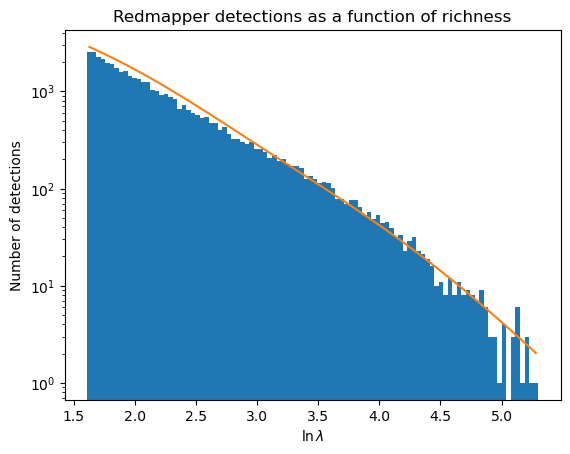

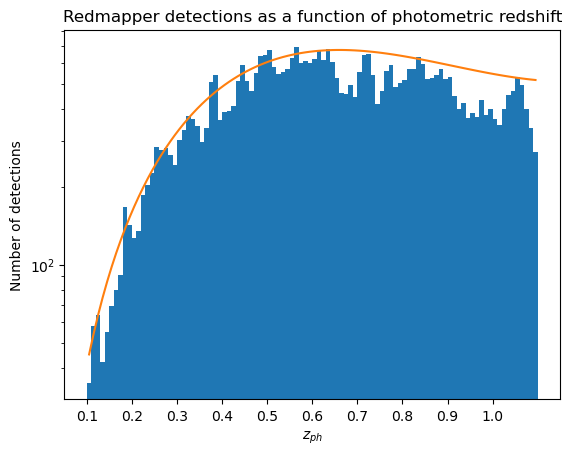

In [9]:
mulf = Nc.MultiplicityFuncDespali.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)
#mulf.set_Delta(200.0)

# Discutivel
mulf_tinker = Nc.MultiplicityFuncTinker.new()
mulf_tinker.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf_tinker.set_Delta(200.0)
hmf_tinker = Nc.HaloMassFunction.new(dist, psf, mulf_tinker)
hmf_tinker.prepare(cosmo)
hmf_tinker.set_area(sky_area * (np.pi / 180) ** 2)
hbias_tinker = Nc.HaloBiasTinker.new(hmf_tinker)


hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.prepare(cosmo)
hmf.set_area(sky_area * (np.pi / 180) ** 2)
hbias = Nc.HaloBiasDespali.new(hmf)
cad = Nc.ClusterAbundance.new(hmf,hbias)
cad.set_area(sky_area * (np.pi / 180) ** 2)



cad.prepare(cosmo , cluster_z , cluster_m)
print(cad.n(cosmo ,cluster_z , cluster_m))
red_mapper_20 = data_redmapper[(data_redmapper['richness']>= cut) & (data_redmapper['richness'] < lnR_max) & (data_redmapper['redshift'] >= pz_min) & (data_redmapper['redshift'] < pz_max)]
print(len(red_mapper_20['richness']))



nbins=100
lnM_obs = np.linspace(cut, np.log(200) , nbins +1)
lnM_obs_bin = [(lnM_obs[i] +lnM_obs[i+1])/2 for i in range(len(lnM_obs)-1)]
z_obs = np.linspace(z_bins_knots[0], z_bins_knots[-1] , nbins +1)
z_obs_bin = [(z_obs[i] +z_obs[i+1])/2 for i in range(len(z_obs)-1)]
abundance_lnM = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnM_obs[i]] , [lnM_obs[i+1]], None, [pz_min] , [pz_max] , [0.00,0.03])  for i in range(len(lnM_obs)-1)]
abundance_z = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [cut] , [lnR_max], None, [z_obs[i]] , [z_obs[i+1]] , [0.00,0.03 * (1 + z_obs_bin[i])])  for i in range(len(z_obs)-1)]
#abundance_bias = [cad.intp_bin_d2n_bias(cosmo, cluster_z, cluster_m, [lnM_obs[i]] , [lnM_obs[i+1]], None, [pz_min] , [pz_max] , [0.00,0.03])  for i in range(len(lnM_obs)-1)]


plt.hist(red_mapper_20['richness'],bins=lnM_obs)
plt.plot(lnM_obs_bin,abundance_lnM)
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper detections as a function of richness")
plt.savefig("detections_R.png")
plt.show()

plt.hist(red_mapper_20['redshift'],bins=z_obs)
plt.plot(z_obs_bin,abundance_z)
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$z_{ph}$")
plt.xticks(np.arange(0.1, 1.1, step=0.1))
plt.title("Redmapper detections as a function of photometric redshift")
plt.savefig("detections_z.png")
plt.show()
'''
plt.hist(red_mapper_20['richness'],bins=lnM_obs)
plt.plot(lnM_obs_bin,abundance_bias)
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Bias of detections")
plt.xlabel(r"$\ln \lambda$")
plt.show()
'''
#Mset Preparation
mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
mset.prepare_fparam_map()
dset = Ncm.Dataset.new()

# Cluster counts binned likelihood

## S matrix 

In [10]:
kernel_z = np.linspace(0.0, 1.9, num=400 + 1)[1:]
kernels_T = np.zeros((len(z_bins_knots)-1, 400))
for i, (zminbin, zmaxbin) in enumerate(zip(z_bins_knots[:-1], z_bins_knots[1:])):
        Dz = zmaxbin - zminbin

        kernel = np.zeros_like(kernel_z)
        kernel[(kernel_z >= zminbin) & (kernel_z <= zmaxbin)] = 1.0
        kernels_T[i] = kernel / Dz
    
S_fullsky_array = PySSC.Sij(kernel_z, kernels_T, cosmo)
S_fullsky = Ncm.Matrix.new_array(S_fullsky_array.flatten(), S_fullsky_array.shape[1])

mean: 574.0000000000 129.0000000000 28.0000000000 42.0000000000 21.0000000000 6.0000000000 3.0000000000 1574.0000000000 312.0000000000 109.0000000000 142.0000000000 73.0000000000 14.0000000000 6.0000000000 2626.0000000000 549.0000000000 212.0000000000 255.0000000000 104.0000000000 13.0000000000 6.0000000000 3626.0000000000 750.0000000000 264.0000000000 305.0000000000 137.0000000000 17.0000000000 17.0000000000 4326.0000000000 887.0000000000 337.0000000000 362.0000000000 122.0000000000 19.0000000000 12.0000000000 3776.0000000000 880.0000000000 349.0000000000 377.0000000000 153.0000000000 31.0000000000 14.0000000000 3735.0000000000 860.0000000000 348.0000000000 312.0000000000 139.0000000000 21.0000000000 7.0000000000 6526.0000000000 1522.0000000000 667.0000000000 653.0000000000 288.0000000000 32.0000000000 22.0000000000 2775.0000000000 677.0000000000 254.0000000000 243.0000000000 102.0000000000 14.0000000000 5.0000000000
[652.07780487 139.29969614  54.77138682  57.40235783  30.53477966
  

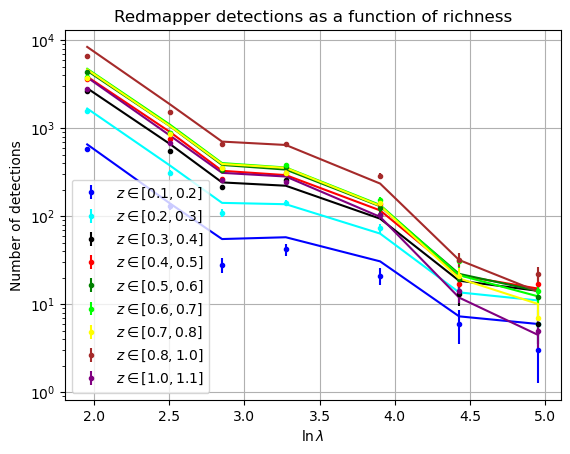

In [ ]:
bin_counts = []
bin_counts_pure_complete = []
for i in range(len(z_bins_knots)-1):
    bins_coutns_z_i = red_mapper_20[(red_mapper_20['redshift'] >= z_bins_knots[i]) * (red_mapper_20['redshift'] < z_bins_knots[i+1])]

    for j in range(len(lnR_bins_knots)-1):
        bin_counts.append(len(bins_coutns_z_i[(bins_coutns_z_i['richness'] >= lnR_bins_knots[j]) * (bins_coutns_z_i['richness'] < lnR_bins_knots[j+1]
                                                                                                  )]))
        bin_counts_pure_complete.append( len(bins_coutns_z_i[(bins_coutns_z_i['richness'] >= lnR_bins_knots[j]) * (bins_coutns_z_i['richness'] < lnR_bins_knots[j+1]
                                                                                                  )]))

z_bins_vec = Ncm.Vector.new_array(npa_to_seq(z_bins_knots))
lnR_bins_vec = Ncm.Vector.new_array(npa_to_seq(lnR_bins_knots))

nc_data_binned = Nc.DataClusterNCountsGauss.new(cad)
nc_data_binned.set_size((z_bins_vec.len() - 1) * (lnR_bins_vec.len() - 1))
nc_data_binned.set_init(True)
nc_data_binned.use_norma(True)
nc_data_binned.set_z_obs(z_bins_vec)
nc_data_binned.set_z_obs_params(photoz_err)
nc_data_binned.set_lnM_obs(lnR_bins_vec)
nc_data_binned.set_has_ssc(True)
nc_data_binned.set_s_matrix(S_fullsky)
nc_data_binned.set_fix_cov(False)

nc_data_binned.peek_mean().set_array(npa_to_seq(bin_counts))
nc_data_binned.peek_mean().log_vals("mean: " , "%.10f", True)
#nc_data_binned.peek_cov().log_vals("cov" , "%.10f")
#S_fullsky.log_vals("S" , "%.10f")
    
dset.append_data(nc_data_binned)
# Likelihood
lh = Ncm.Likelihood.new(dset)
color_list = ["blue","cyan" , "black", "red" , "green","lime" , "yellow", "brown" , "purple", ]
for i in range(len(z_bins_knots)-1):
    abundance_lnR = np.array  ([cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnR_bins_knots[j]] , [lnR_bins_knots[j+1]], None, [z_bins_knots[i]] , [z_bins_knots[i+1]] , [0.00,sigma[i]]) for j in range(len(lnR_bins_knots)-1)])
    lnR_bins = [(lnR_bins_knots[j] + lnR_bins_knots[j+1])/2 for j in range(len(lnR_bins_knots)-1)]
    bin_counts_z = [bin_counts[ i * (len(lnR_bins_knots)-1) + j] for j in range(len(lnR_bins_knots)-1)]
    err_bin_counts_z = [np.sqrt(bin_counts[ i * (len(lnR_bins_knots)-1) + j]) for j in range(len(lnR_bins_knots)-1)]
    if i <1001:
        plt.errorbar(lnR_bins, bin_counts_z, yerr=err_bin_counts_z,label=r"$z \in [%.1f,%.1f]$" % (z_bins_knots[i] , z_bins_knots[i+1]),fmt='.',color=color_list[i])
        plt.plot(lnR_bins,abundance_lnR,color=color_list[i])

    print(abundance_lnR, "\n")



    
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper detections as a function of richness")
plt.grid()
plt.legend(loc='best')
plt.show()

## Has SSC

In [ ]:
nc_data_binned.set_has_ssc(False)
#Mset Preparation
mset = Ncm.MSet.new_array([cluster_m, cosmo, cluster_z])
mfunc_oa = Ncm.ObjArray.new()
mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
mfunc_oa.add(mfunc_sigma8)
mset.prepare_fparam_map()
dset = Ncm.Dataset.new()

fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit.log_info()
fit.run(Ncm.FitRunMsgs.SIMPLE)
fit.log_info()
fit.obs_fisher()
fit.log_covar()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterNCountsGauss
#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : XCDM - Constant EOS
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.22                [FREE]
#   -     Omegax[02]:  0.7352              [FIXED]
#   -    Tgamma0[03]:  2.7245              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]
#   -          w[07]: -1                   [FREE]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#-------------------------------------------------------------------

In [ ]:
nwalkers = 500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new_funcs_array(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL,mfunc_oa)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("mcmc_binned.fits")

esmcmc.start_run()
esmcmc.run(400)
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()

# Cluster counts unbinned likelihood

In [ ]:
ncdata = Nc.DataClusterNCount.new(cad, "NcClusterPhotozGauss", "NcClusterMassAscaso")
ncdata.set_init(True)
lnM_obs = Ncm.Matrix.new(len(red_mapper_20['richness']),1)
z_obs   = Ncm.Matrix.new(len(red_mapper_20['redshift']),1)
z_obs_params  = Ncm.Matrix.new(len(red_mapper_20['redshift_err']),2)                        

for i in range(len(red_mapper_20['richness'])):
    lnM_obs.set(i,0, red_mapper_20['richness'][i])
    z_obs.set(i,0,red_mapper_20['redshift'][i])
    for j in range(0, 2):
        if j == 1:
            z_obs_params.set(i, j, red_mapper_20['redshift_err'][i])
        if j == 0:
            z_obs_params.set(i, j, 0.0)

ncdata.set_lnM_obs(lnM_obs)
ncdata.set_z_obs(z_obs)
ncdata.set_z_obs_params(z_obs_params)
ncdata.true_data(False)


dset.append_data(ncdata)
# Likelihood
lh = Ncm.Likelihood.new(dset)

# Fit

In [ ]:
fit = Ncm.Fit.factory(
    Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL
)

fit.log_info()
fit.run(Ncm.FitRunMsgs.SIMPLE)
fit.log_info()
fit.obs_fisher()
fit.log_covar()g

In [ ]:
nwalkers = 500

Ncm.func_eval_set_max_threads(2)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.FULL)
esmcmc.set_nthreads(2)
esmcmc.set_data_file("MCMC_unbinned.fits")

esmcmc.start_run()
esmcmc.run(400)
esmcmc.end_run()

esmcmc.mean_covar()
fit.log_covar()